In [1]:
import numpy as np
import scanpy as sc
import matplotlib.patches as patches
import pandas as pd
from scipy.stats import pearsonr
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

In [2]:
def overlap_bygrids(slice1, slice2, spatial_key1, spatial_key2, m, n):
    adata1=slice1.copy()
    adata2=slice2.copy()
    coords1 = adata1.obsm[spatial_key1]
    coords2 = adata2.obsm[spatial_key2]

    x_min = max(np.min(coords1[:, 0]), np.min(coords2[:, 0]))
    x_max = min(np.max(coords1[:, 0]), np.max(coords2[:, 0]))
    y_min = max(np.min(coords1[:, 1]), np.min(coords2[:, 1]))
    y_max = min(np.max(coords1[:, 1]), np.max(coords2[:, 1]))

    def points_per_grid(coords, x_min, x_max, y_min, y_max, m, n):#ponits:spots/cells
        grid_points_counts = []
        for i in range(n):
            for j in range(m):
                x_start = x_min + i * (x_max - x_min) / n
                y_start = y_min + j * (y_max - y_min) / m
                x_end = x_start + (x_max - x_min) / n
                y_end = y_start + (y_max - y_min) / m
                ponits_count = np.sum((coords[:, 0] >= x_start) & (coords[:, 0] < x_end) &
                                    (coords[:, 1] >= y_start) & (coords[:, 1] < y_end))
                grid_points_counts.append(ponits_count)
        return np.mean(grid_points_counts)

    average_cells = min(
        points_per_grid(coords1, x_min, x_max, y_min, y_max, m, n),
        points_per_grid(coords2, x_min, x_max, y_min, y_max, m, n)
    )
    threshold_points = average_cells / 2

    def check_grid_area(adata_coords, x_start, y_start, x_end, y_end, threshold_points):
        points_in_grid = adata_coords[(adata_coords[:, 0] >= x_start) & (adata_coords[:, 0] < x_end) &
                                      (adata_coords[:, 1] >= y_start) & (adata_coords[:, 1] < y_end)]
        return len(points_in_grid) >= threshold_points

    # Prepare the 'grid_label' column in .obs with None
    adata1.obs['grid_label'] = None
    adata2.obs['grid_label'] = None

    grid_counter = 1
    for i in range(n):
        for j in range(m):
            x_start = x_min + i * (x_max - x_min) / n
            y_start = y_min + j * (y_max - y_min) / m
            x_end = x_start + (x_max - x_min) / n
            y_end = y_start + (y_max - y_min) / m

            in_adata1 = check_grid_area(coords1, x_start, y_start, x_end, y_end, threshold_points)
            in_adata2 = check_grid_area(coords2, x_start, y_start, x_end, y_end, threshold_points)

            label = f"Grid_{grid_counter}" if in_adata1 and in_adata2 else "NonOverlap"

            adata1.obs.loc[(coords1[:, 0] >= x_start) & (coords1[:, 0] < x_end) &
                           (coords1[:, 1] >= y_start) & (coords1[:, 1] < y_end), 'grid_label'] = label

            adata2.obs.loc[(coords2[:, 0] >= x_start) & (coords2[:, 0] < x_end) &
                           (coords2[:, 1] >= y_start) & (coords2[:, 1] < y_end), 'grid_label'] = label

            if in_adata1 and in_adata2:
                grid_counter += 1

    return adata1,adata2

In [3]:
def plot_with_grids_and_labels(adata1, adata2, spatial_key1, spatial_key2, n, m):
    coords1 = adata1.obsm[spatial_key1]
    coords2 = adata2.obsm[spatial_key2]

    plt.figure(figsize=(10, 10))

    plt.scatter(coords1[:, 0], coords1[:, 1], s=1, label='adata1')
    plt.scatter(coords2[:, 0], coords2[:, 1], s=1, label='adata2')

    x_min = max(np.min(coords1[:, 0]), np.min(coords2[:, 0]))
    x_max = min(np.max(coords1[:, 0]), np.max(coords2[:, 0]))
    y_min = max(np.min(coords1[:, 1]), np.min(coords2[:, 1]))
    y_max = min(np.max(coords1[:, 1]), np.max(coords2[:, 1]))

    for i in range(n):  
        for j in range(m): 
            x_start = x_min + i * (x_max - x_min) / n
            y_start = y_min + j * (y_max - y_min) / m
            x_end = x_start + (x_max - x_min) / n
            y_end = y_start + (y_max - y_min) / m

            labels1 = adata1.obs.loc[
                (adata1.obsm[spatial_key1][:, 0] >= x_start) & (adata1.obsm[spatial_key1][:, 0] < x_end) &
                (adata1.obsm[spatial_key1][:, 1] >= y_start) & (adata1.obsm[spatial_key1][:, 1] < y_end), 'grid_label']
            labels2 = adata2.obs.loc[
                (adata2.obsm[spatial_key2][:, 0] >= x_start) & (adata2.obsm[spatial_key2][:, 0] < x_end) &
                (adata2.obsm[spatial_key2][:, 1] >= y_start) & (adata2.obsm[spatial_key2][:, 1] < y_end), 'grid_label']

            if len(labels1) == 0 or labels1.values[0] == 'NonOverlap' or labels1.isnull().values.any():
                label = None
            else:
                label = labels1.values[0]

            if label is not None:              
                rect = patches.Rectangle((x_start, y_start), (x_end - x_start), (y_end - y_start),
                                         linewidth=1, edgecolor='black', facecolor='none')
                plt.gca().add_patch(rect)
                number = label.split('_')[-1]
                plt.text((x_start + x_end) / 2, (y_start + y_end) / 2, f'{number}',
                         horizontalalignment='center', verticalalignment='center', fontsize=10, color='black')

    plt.legend()
    plt.show()

### PCC

In [4]:
def PCC_bygrid(slice1, slice2, gene_name):
    adata1, adata2 = overlap_bygrids(slice1, slice2, 'spatial', 'spatial', m=10, n=10)

    if gene_name not in adata1.var_names or gene_name not in adata2.var_names:
        raise ValueError(f"Gene {gene_name} not found in both of the slices.")

    gene_expression1 = adata1.X[:, adata1.var_names == gene_name].toarray().squeeze()
    gene_expression2 = adata2.X[:, adata2.var_names == gene_name].toarray().squeeze()

    df1 = pd.DataFrame({'expression': gene_expression1, 'grid_label': adata1.obs['grid_label']})
    df2 = pd.DataFrame({'expression': gene_expression2, 'grid_label': adata2.obs['grid_label']})

    df1 = df1[(df1['grid_label'] != 'NonOverlap') & (df1['grid_label'].notnull())]
    df2 = df2[(df2['grid_label'] != 'NonOverlap') & (df2['grid_label'].notnull())]

    mean_expression1 = df1.groupby('grid_label').mean().sort_index()
    mean_expression2 = df2.groupby('grid_label').mean().sort_index()

    if mean_expression1.size<2 or mean_expression2.size<2:
        PCC=0
    else:
        PCC,pvalue=pearsonr(mean_expression1['expression'], mean_expression2['expression'])
    return PCC

### Cos_Sim

In [5]:
def cos_sim_bygrid(slice1, slice2, gene_name):
    adata1, adata2 = overlap_bygrids(slice1, slice2, 'spatial', 'spatial', m=10, n=10)

    if gene_name not in adata1.var_names or gene_name not in adata2.var_names:
        raise ValueError(f"Gene {gene_name} not found in both of the slices.")

    gene_expression1 = adata1.X[:, adata1.var_names == gene_name].toarray().squeeze()
    gene_expression2 = adata2.X[:, adata2.var_names == gene_name].toarray().squeeze()

    df1 = pd.DataFrame({'expression': gene_expression1, 'grid_label': adata1.obs['grid_label']})
    df2 = pd.DataFrame({'expression': gene_expression2, 'grid_label': adata2.obs['grid_label']})

    df1 = df1[(df1['grid_label'] != 'NonOverlap') & (df1['grid_label'].notnull())]
    df2 = df2[(df2['grid_label'] != 'NonOverlap') & (df2['grid_label'].notnull())]

    mean_expression1 = np.array(df1.groupby('grid_label').mean().sort_index()).squeeze()
    mean_expression2 =  np.array(df2.groupby('grid_label').mean().sort_index()).squeeze()

    if mean_expression1.size<2 or mean_expression2.size<2:
        cos_sim=0
    else:
        cos_sim = mean_expression1.dot(mean_expression2) / (np.linalg.norm(mean_expression1) * np.linalg.norm(mean_expression2))
    return cos_sim

### SSIM

In [6]:
def ssim_bygrid(slice1, slice2, gene_name, L=1):
    adata1, adata2 = overlap_bygrids(slice1, slice2, 'spatial', 'spatial', m=10, n=10)

    if gene_name not in adata1.var_names or gene_name not in adata2.var_names:
        raise ValueError(f"Gene {gene_name} not found in both of the slices.")

    gene_expression1 = adata1.X[:, adata1.var_names == gene_name].toarray().squeeze()
    gene_expression2 = adata2.X[:, adata2.var_names == gene_name].toarray().squeeze()

    df1 = pd.DataFrame({'expression': gene_expression1, 'grid_label': adata1.obs['grid_label']})
    df2 = pd.DataFrame({'expression': gene_expression2, 'grid_label': adata2.obs['grid_label']})

    df1 = df1[(df1['grid_label'] != 'NonOverlap') & (df1['grid_label'].notnull())]
    df2 = df2[(df2['grid_label'] != 'NonOverlap') & (df2['grid_label'].notnull())]

    mean_expression1 = np.array(df1.groupby('grid_label').mean().sort_index()).squeeze()
    mean_expression2 = np.array(df2.groupby('grid_label').mean().sort_index()).squeeze()

    if mean_expression1.size<2 or mean_expression2.size<2:
        ssim=0
    else:        
        mean_expression1, mean_expression2 = mean_expression1/mean_expression1.max(), mean_expression2/mean_expression2.max()
        mu1 = mean_expression1.mean()
        mu2 = mean_expression2.mean()
        sigma1 = np.sqrt(((mean_expression1 - mu1) ** 2).mean())
        sigma2 = np.sqrt(((mean_expression2 - mu2) ** 2).mean())
        sigma12 = ((mean_expression1 - mu1) * (mean_expression2 - mu2)).mean()
        k1, k2= 0.01, 0.03
        C1 = (k1*L) ** 2
        C2 = (k2*L) ** 2
        C3 = C2/2
        l12 = (2*mu1*mu2 + C1)/(mu1 ** 2 + mu2 ** 2 + C1)
        c12 = (2*sigma1*sigma2 + C2)/(sigma1 ** 2 + sigma2 ** 2 + C2)
        s12 = (sigma12 + C3)/(sigma1*sigma2 + C3)
        ssim = l12 * c12 * s12
    return ssim

### MI

In [7]:
def MI_bygrid(slice1, slice2, gene_name):
    adata1, adata2 = overlap_bygrids(slice1, slice2, 'spatial', 'spatial', m=10, n=10)

    if gene_name not in adata1.var_names or gene_name not in adata2.var_names:
        raise ValueError(f"Gene {gene_name} not found in both of the slices.")

    gene_expression1 = adata1.X[:, adata1.var_names == gene_name].toarray().squeeze()
    gene_expression2 = adata2.X[:, adata2.var_names == gene_name].toarray().squeeze()

    df1 = pd.DataFrame({'expression': gene_expression1, 'grid_label': adata1.obs['grid_label']})
    df2 = pd.DataFrame({'expression': gene_expression2, 'grid_label': adata2.obs['grid_label']})

    df1 = df1[(df1['grid_label'] != 'NonOverlap') & (df1['grid_label'].notnull())]
    df2 = df2[(df2['grid_label'] != 'NonOverlap') & (df2['grid_label'].notnull())]

    mean_expression1 = np.array(df1.groupby('grid_label').mean().sort_index())
    mean_expression2 = np.array(df2.groupby('grid_label').mean().sort_index()).squeeze()

    if mean_expression1.size<2 or mean_expression2.size<2:
        mi=[0]
    else:
        mi = mutual_info_regression(mean_expression1, mean_expression2)
    return mi[0]

In [9]:
import os
import re
def load_results(data_dir,pattern):
    slices = []
    files = []
    for filename in os.listdir(data_dir):
        if pattern in filename :
            files.append(filename)
    files.sort(key=lambda x: int(re.search(r'_(\d+)\.h5ad', x).group(1)))
   
    for filename in files:
        file_path = os.path.join(data_dir, filename)
        adata = sc.read_h5ad(file_path)
        slices.append(adata)
 
    return slices

In [10]:
PASTE_DLPFCS=load_results('/SABench/AlignmentResults/PASTE_DLPFCS/','.h5ad')
PASTE_p0_DLPFCS=load_results('/SABench/AlignmentResults/PASTE_p0_DLPFCS/','.h5ad')
PASTE2_DLPFCS=load_results('/SABench/AlignmentResults/PASTE2_DLPFCS/','.h5ad')
STAligner_DLPFCS_landmark0=load_results('/SABench/AlignmentResults/STAligner_DLPFCS/','landmark0')
STAligner_DLPFCS_landmark1=load_results('/SABench/AlignmentResults/STAligner_DLPFCS/','landmark1')
STAligner_DLPFCS_landmark2=load_results('/SABench/AlignmentResults/STAligner_DLPFCS/','landmark2')
STAligner_DLPFCS_landmark3=load_results('/SABench/AlignmentResults/STAligner_DLPFCS/','landmark3')
SLAT_DLPFCS=load_results('/SABench/AlignmentResults/SLAT_DLPFCS/','.h5ad')
STalign_DLPFCS=load_results('/SABench/AlignmentResults/STalign_DLPFCS/','.h5ad')
CAST_DLPFCS=load_results('/SABench/AlignmentResults/CAST_DLPFCS/','.h5ad')
STAIR_DLPFCS=load_results('/SABench/AlignmentResults/STAIR_DLPFCS/','.h5ad')
SPACEL_DLPFCS=load_results('/SABench/AlignmentResults/SPACEL_DLPFCS/','.h5ad')
Spateo_rigid_DLPFCS=load_results('/SABench/AlignmentResults/Spateo_rigid_DLPFCS/','.h5ad')
Spateo_nonrigid_DLPFCS=load_results('/SABench/AlignmentResults/Spateo_nonrigid_DLPFCS/','.h5ad')

In [11]:
all_results=PASTE_DLPFCS+PASTE_p0_DLPFCS+PASTE2_DLPFCS+STAligner_DLPFCS_landmark0+STAligner_DLPFCS_landmark1+STAligner_DLPFCS_landmark2+STAligner_DLPFCS_landmark3+SLAT_DLPFCS+STalign_DLPFCS+CAST_DLPFCS+STAIR_DLPFCS+SPACEL_DLPFCS+Spateo_rigid_DLPFCS+Spateo_nonrigid_DLPFCS
groups=[PASTE_DLPFCS,PASTE_p0_DLPFCS,PASTE2_DLPFCS,STAligner_DLPFCS_landmark0,STAligner_DLPFCS_landmark1,STAligner_DLPFCS_landmark2,STAligner_DLPFCS_landmark3,SLAT_DLPFCS,STalign_DLPFCS,CAST_DLPFCS,STAIR_DLPFCS,SPACEL_DLPFCS,Spateo_rigid_DLPFCS,Spateo_nonrigid_DLPFCS]

## Load gene marker list

In [13]:
#DLPFC gene_list
df = pd.read_csv('/SABench/FeatureSimilarity/spatialLIBD_table_S5.csv', usecols=[4])
gene_list = df.iloc[:, 0].tolist()
valid_genes = []

adata_list=all_results
for gene in gene_list:
    if all(gene in adata_slice.var_names for adata_slice in adata_list):
        valid_genes.append(gene)

gene_list = valid_genes
gene_list = [x for i, x in enumerate(gene_list) if i not in [72, 77,120]]

In [14]:
len(gene_list)

123

### Avg_pcc

In [15]:
def Avg_pcc_values_for_method(method_results, gene_list):
    pcc_values = []
    for i in range(len(method_results)-1):
        slice1 = method_results[i]
        slice2 = method_results[i+1]
        pcc_values_pair = []
        for gene_name in gene_list:
            pcc = PCC_bygrid(slice1, slice2, gene_name)
            pcc_values_pair.append(pcc)
        pcc_values.append(pcc_values_pair)
    average_pcc = np.mean(np.array(pcc_values), axis=0).tolist()
    return average_pcc

In [16]:
groups

[[AnnData object with n_obs × n_vars = 3611 × 33538
      obs: 'in_tissue', 'array_row', 'array_col', 'Region'
      var: 'gene_ids', 'feature_types', 'genome'
      uns: 'Region_colors', 'spatial'
      obsm: 'spatial',
  AnnData object with n_obs × n_vars = 3635 × 33538
      obs: 'in_tissue', 'array_row', 'array_col', 'Region'
      var: 'gene_ids', 'feature_types', 'genome'
      uns: 'Region_colors', 'spatial'
      obsm: 'spatial',
  AnnData object with n_obs × n_vars = 3566 × 33538
      obs: 'in_tissue', 'array_row', 'array_col', 'Region'
      var: 'gene_ids', 'feature_types', 'genome'
      uns: 'Region_colors', 'spatial'
      obsm: 'spatial',
  AnnData object with n_obs × n_vars = 3431 × 33538
      obs: 'in_tissue', 'array_row', 'array_col', 'Region'
      var: 'gene_ids', 'feature_types', 'genome'
      uns: 'Region_colors', 'spatial'
      obsm: 'spatial'],
 [AnnData object with n_obs × n_vars = 3611 × 33538
      obs: 'in_tissue', 'array_row', 'array_col', 'Region'
    

In [17]:
all_methods_pcc_values = [Avg_pcc_values_for_method(group, gene_list) for group in groups]

### Avg_cos_sim

In [18]:
def Avg_cos_sim_values_for_method(method_results, gene_list):
    cos_sim_values = []
    for i in range(len(method_results)-1):
        slice1 = method_results[i]
        slice2 = method_results[i+1]
        cos_sim_values_pair = []
        for gene_name in gene_list:
            cos_sim = cos_sim_bygrid(slice1, slice2, gene_name)
            cos_sim_values_pair.append(cos_sim)
        cos_sim_values.append(cos_sim_values_pair)
    average_cos_sim = np.mean(np.array(cos_sim_values), axis=0).tolist()
    return average_cos_sim

In [19]:
all_methods_cos_sim_values = [Avg_cos_sim_values_for_method(group, gene_list) for group in groups]

### Avg_ssim

In [20]:
def Avg_ssim_values_for_method(method_results, gene_list):
    ssim_values = []
    for i in range(len(method_results)-1):
        slice1 = method_results[i]
        slice2 = method_results[i+1]
        ssim_values_pair = []
        for gene_name in gene_list:
            ssim = ssim_bygrid(slice1, slice2, gene_name)
            ssim_values_pair.append(ssim)
        ssim_values.append(ssim_values_pair)
    average_ssim = np.mean(np.array(ssim_values), axis=0).tolist()
    return average_ssim

In [21]:
all_methods_ssim_values = [Avg_ssim_values_for_method(group, gene_list) for group in groups]

### MI

In [22]:
def Avg_MI_values_for_method(method_results, gene_list):
    MI_values = []
    for i in range(len(method_results)-1):
        slice1 = method_results[i]
        slice2 = method_results[i+1]
        MI_values_pair = []
        for gene_name in gene_list:
            MI = MI_bygrid(slice1, slice2, gene_name)
            MI_values_pair.append(MI)
        MI_values.append(MI_values_pair)
    average_MI = np.mean(np.array(MI_values), axis=0).tolist()
    return average_MI

In [23]:
all_methods_MI_values = [Avg_MI_values_for_method(group, gene_list) for group in groups]

### boxplot

In [26]:
def Custom_boxplot(data, colors=['#ACD7A8', '#A5DEF1', '#6B95C5', '#FAE791', '#FAAD73','#B5D4E9'], title='Boxplot', xlabel='Category', ylabel='Values'):

    bp = plt.boxplot(data, patch_artist=True)

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('#333333')  
        patch.set_linewidth(1)

    for median in bp['medians']:
        median.set(color='black', linewidth=1)

    for whisker in bp['whiskers']:
        whisker.set(color='#333333', linewidth=1)

    for cap in bp['caps']:
        cap.set(color='#333333', linewidth=1)

    for flier in bp['fliers']:
        flier.set(marker='o', color='#333333', alpha=0.5)

    plt.xticks(range(1, len(groups) + 1), ['PASTE_DLPFCS','PASTE_p0_DLPFCS','PASTE2_DLPFCS','STAligner_DLPFCS_landmark0','STAligner_DLPFCS_landmark1','STAligner_DLPFCS_landmark2','STAligner_DLPFCS_landmark3','SLAT_DLPFCS','STalign_DLPFCS','CAST_DLPFCS','STAIR_DLPFCS','SPACEL_DLPFCS','Spateo_rigid_DLPFCS','Spateo_nonrigid_DLPFCS'],rotation=70)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [27]:
color=['#f7fcf0','#e0f3db','#ccebc5','#daf5fbff','#caf0f8ff','#ade8f4ff','#50a9d7','#2b8cbe','#225ea8','#9D9ECD','#ffc6a0','#ffb19f','#ff968b','#f28682']

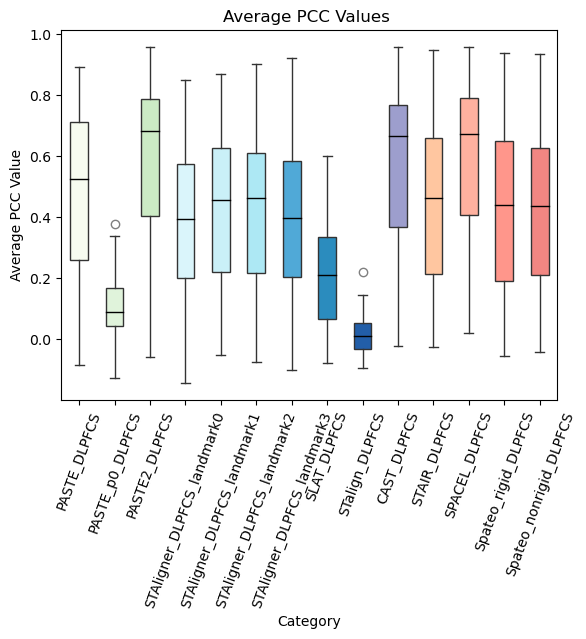

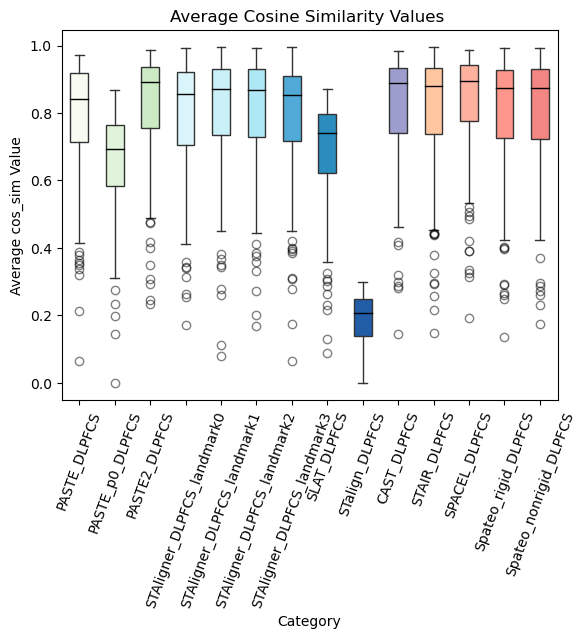

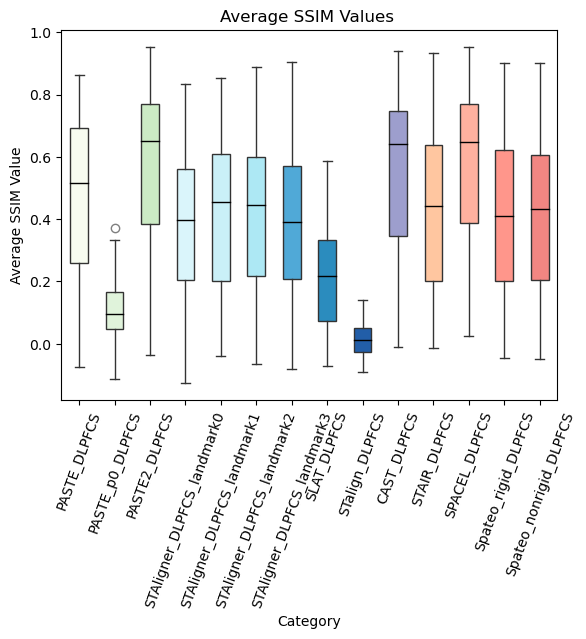

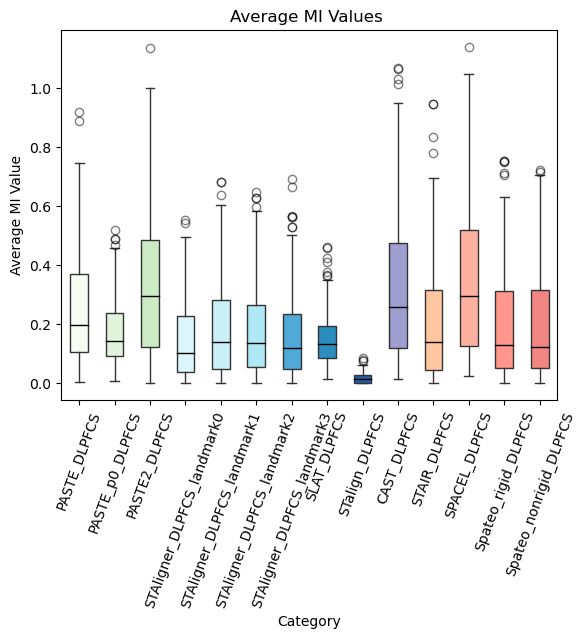

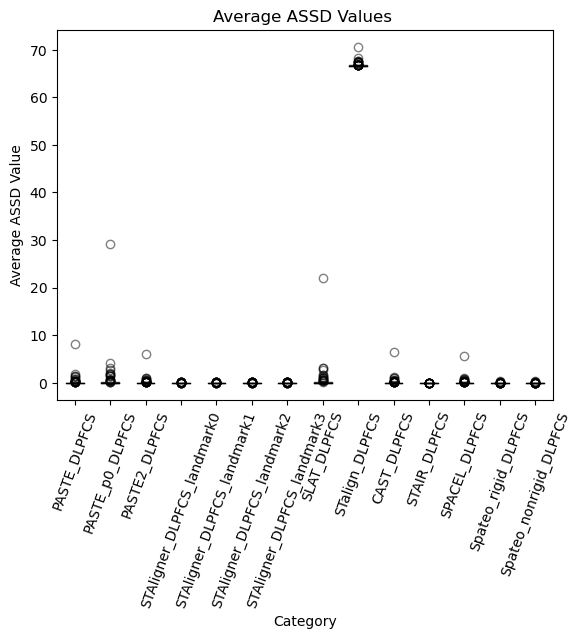

In [28]:
Custom_boxplot(all_methods_pcc_values,color,title='Average PCC Values ',ylabel='Average PCC Value')
Custom_boxplot(all_methods_cos_sim_values,color,title='Average Cosine Similarity Values ',ylabel='Average cos_sim Value')
Custom_boxplot(all_methods_ssim_values,color,title='Average SSIM Values ',ylabel='Average SSIM Value')
Custom_boxplot(all_methods_MI_values,color,title='Average MI Values ',ylabel='Average MI Value')
Custom_boxplot(all_methods_ASSD_values,color,title='Average ASSD Values ',ylabel='Average ASSD Value')